**Mount Google Drive to access the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Download Transformers**

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.8 MB/s eta 0:00:00


**Data Description**

In this task, the dataset contains different couples of sentences (a premise and a hypothesis) in different languages. Each couple has a label of one out of three classes:

•	**Entailment**: the two sentences a related in meaning

•	**Neutral**: the sentences are neither related nor contraries

•	**Contradiction**: the sentences are contraries in meaning

***The data set contains two csv files:***

- train.csv: This file contains the ID, premise, hypothesis, and label, as well as the language of the text and its two-letter abbreviation

- test.csv: This file contains the ID, premise, hypothesis, language, and language abbreviation, without labels.

We will develop a model, which will classify only English sentences couples in one of the mentioned classes.


**Import Required packages**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer,TFRobertaModel, RobertaTokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Train Data
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
english_trian_data = pd.DataFrame()

# Test Data
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')
english_test_data = pd.DataFrame()

**Extract English Samples**

To separate the English sentences in the train and test data set depending on the language two-letter abbreviation label in the csv files. After extracting all English sentences the new csv files containing (train.csv, test.csv) these sentences are saved.

In [ ]:
# Train
for row in range(1,len(train_data)):
  #Find the language of the sample
  language = str(train_data.iloc[row]['lang_abv'])
  #If English, append to the english_data
  if language == 'en':
     english_trian_data = pd.concat([english_trian_data, train_data.iloc[[row]]], ignore_index=True)

#save english_data csv file
english_trian_data.to_csv('train_english.csv')

#Test
for row in range(1,len(test_data)):
  #Find the language of the sample
  language = str(test_data.iloc[row]['lang_abv'])
  #if English, append to the english_data
  if language == 'en':
     english_test_data = pd.concat([english_test_data, test_data.iloc[[row]]], ignore_index=True)

#save english_data csv file
english_test_data.to_csv('test_english.csv')

print('English Train Data Size: ', len(english_trian_data))
print('English Test Data Size: ', len(english_test_data))

English Train Data Size:  6869
English Test Data Size:  2945


**Define Parameters**

In [ ]:
BATCH_SIZE = 64
DROPOUT = 0.3
english_samples_path = '/content/drive/MyDrive/train_english.csv'
sequence_length = 128

**Call RoBERTa Tokenizer and Model with TPU**

In [ ]:
with strategy.scope():
    # Load the pre-trained BERT tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

**Load Tokenizer**

In natural language processing (NLP), a tokenizer is a tool that splits text into smaller chunks called tokens. These tokens can be individual words or groups of words that are meaningful together, such as named entities or phrases. 

The Tokenizer class in TensorFlow's Keras API is a text-preprocessing tool that can be used to tokenize text data by converting text into sequences of integers that can be fed into a neural network.

We use RobertaTokenizer that is a tokenizer class provided by the Hugging Face Transformers library, is used to convert text data into numerical sequences that can be fed into a deep learning model such as BERT, RoBERTa, or other transformer-based models. It is specifically designed to work with the RoBERTa model architecture and is based on the Byte-Pair Encoding (BPE) algorithm.
The tokenizer concatenate both premise and hypothesis sentences and tokenize them together with enabling both truncation and padding of the input sequences to ensure that they have the same length.

This code creates a Dataset object from the training encodings and labels. It first creates a tuple of (input_ids, attention_mask) dictionary and the corresponding labels. Finally, the batch method batches the dataset with a specified batch size BATCH_SIZE. The resulting train_dataset and val_dataset is a TensorFlow dataset object that can be used for training the model.


In [ ]:
# Load the training and test datasets
train_df = pd.read_csv(english_samples_path)
#test_df = pd.read_csv('/content/drive/MyDrive/test_english.csv')

# Split the data into training and validation sets
train_df, test_df = train_test_split(train_df, test_size=0.05, random_state=2)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=2)

# Load the pre-trained BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the input sentences and encode the labels
train_encodings = tokenizer(train_df['premise'].tolist(), train_df['hypothesis'].tolist(), truncation=True, padding=True, max_length=sequence_length)
train_labels = train_df['label'].tolist()

val_encodings = tokenizer(val_df['premise'].tolist(), val_df['hypothesis'].tolist(), truncation=True, padding=True, max_length=sequence_length)
val_labels = val_df['label'].tolist()

test_encodings = tokenizer(test_df['premise'].tolist(), test_df['hypothesis'].tolist(), truncation=True, padding=True, max_length=sequence_length)
test_labels = test_df['label'].tolist()

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

**Create TensorFlow datasets from the tokenized data**

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(10000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).shuffle(10000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(BATCH_SIZE)

**Some Statistics about the training Dataset**

English samples occupy 56.7% of the dataset

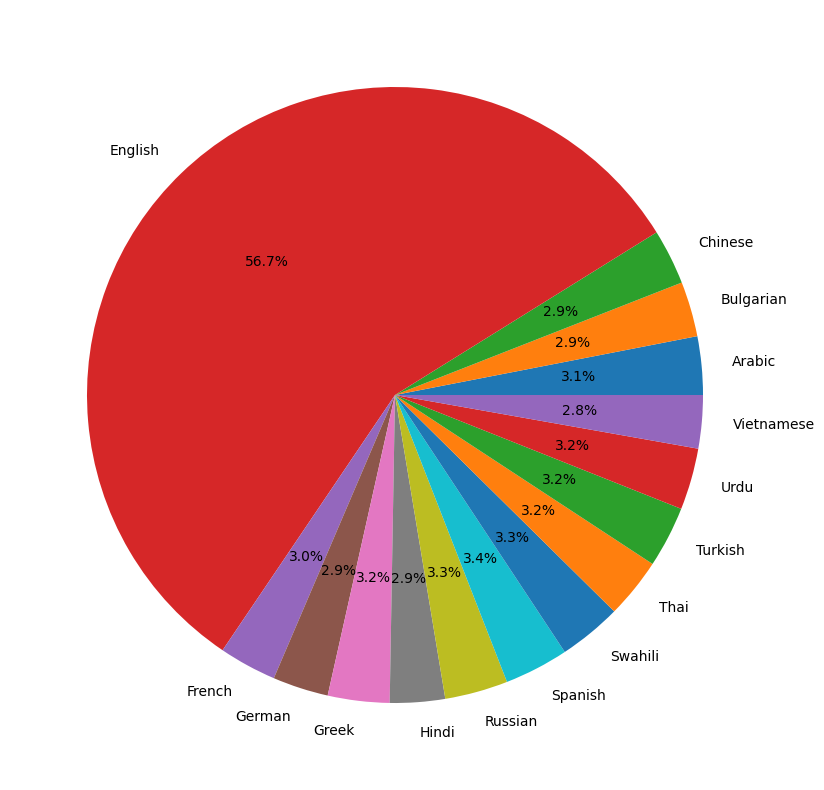

In [ ]:
labels, frequencies = np.unique(test_data.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

The distribution of the three classes in the dataset is almost the same:

•	0: entailment

•	1: neutral

•	2: contradiction


0.0    1240
2.0    1174
1.0    1051
Name: label, dtype: int64


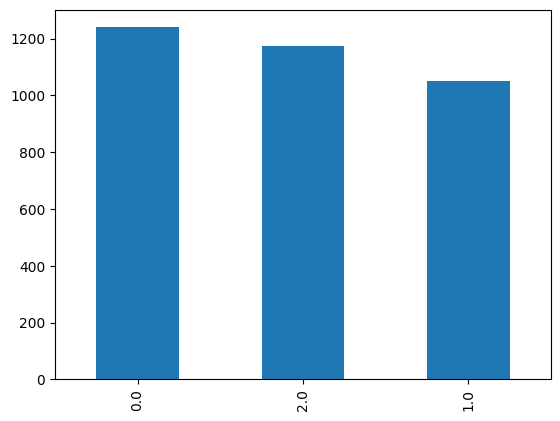

In [ ]:
train_df['label'].value_counts().plot.bar()
print(train_df['label'].value_counts())

Some statistical information of the samples in term of the number characters of samples:

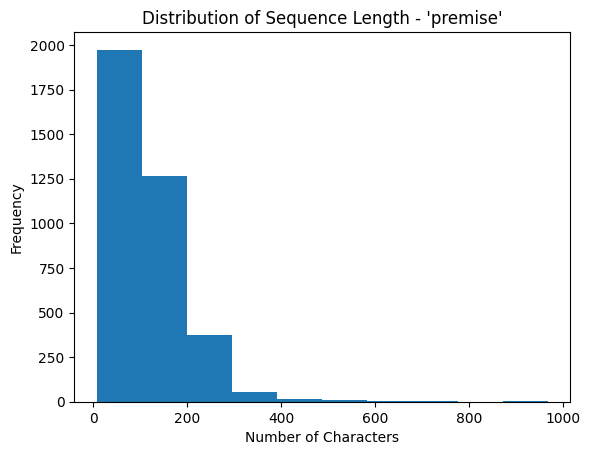

In [ ]:
train_df['premise_nchars'] = train_df['premise'].map(lambda text: len(text))
train_df['premise_nchars'].describe()
train_df['premise_nchars'].plot.hist()
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Length - 'premise'")
plt.show()



---



**Model Architecture**

Our architecture uses RoBERTa (Robustly Optimized BERT Pre-training Approach) which is a state-of-the-art language model based on the Transformer architecture. It was proposed by Facebook AI in 2019 as an improvement to the original BERT (Bidirectional Encoder Representations from Transformers) model. RoBERTa was trained on a large corpus of text using a similar pre-training approach as BERT, but with some modifications such as longer training time, larger batch size, and dynamically changing the masking pattern during pre-training. These modifications resulted in better generalization and higher performance on downstream NLP tasks compared to BERT. RoBERTa uses the same architecture as BERT, which consists of an encoder that is composed of several Transformer blocks. Each Transformer block consists of a self-attention mechanism and a feedforward neural network. RoBERTa is available in several sizes ranging from small to large, with varying numbers of layers and hidden units.

BERT model has two versions:

•	BASE: with 12 transformers layers

•	LARGE: with 24 transformers layers

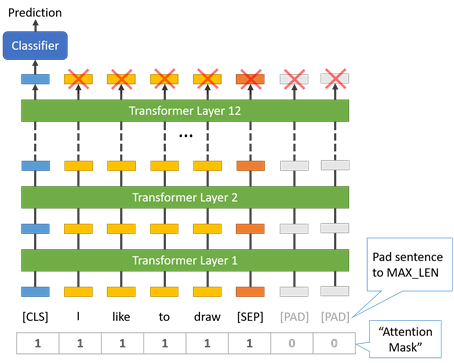

In [ ]:
with strategy.scope():
    # Load the pre-trained RoBERTa model
    bert_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


**Our architecture has two inputs:**

•	*input_ids*:

In RoBERTa, input_ids refers to the tokenized input sequence where each token is mapped to its corresponding token ID in the RoBERTa vocabulary. During tokenization, the input sequence is first split into words, and each word is then split into sub words using Byte Pair Encoding (BPE). Each sub word is then mapped to its corresponding token ID using the RoBERTa tokenizer's vocabulary.

•	*Attension_mask*:

In natural language processing (NLP), the attention mechanism is used to weigh the importance of each word in a sentence when processing the sentence. The attention mask is a binary mask used to indicate which tokens in the input sequence should be attended to by the model, and which tokens should be ignored.


These inputs are then fed to RoBERTa model with the basic per-trained weights with enabling the training of this model. 

the output of the model is the input of two layer in parallel:

•	Global_average_pooling

•	Global_max_pooling

Both operations reduce the spatial dimensions of the feature maps and produce a fixed-length vector for each feature map. 

These vectors are then be concatenated and fed into a classifier for prediction.

In the last part of the architecture we used two Dense Layers with their proper Dropout layers with dropout_rate=0.2 for each.
The first Dense Layer has 64 units and the last with 3 units (equal to the number of classification’s classes).


In [ ]:
with strategy.scope(): 
  # Create a new model that includes the BERT model as a base and add your own layers on top of it
  input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
  bert_output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})
  pooled_output = bert_output[0]
  #pooled_output = pooled_output[:, 0, :]
  #pooled_output =  tf.expand_dims(pooled_output, axis=1)

  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(pooled_output)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(pooled_output)

  vector = tf.keras.layers.Concatenate()([avg_pool, max_pool])

  dropout_layer = tf.keras.layers.Dropout(DROPOUT)(vector)
  dense_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout_layer)
  dropout_layer = tf.keras.layers.Dropout(DROPOUT)(dense_layer)
  dense_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout_layer)
  output_layer = tf.keras.layers.Dense(3, activation='softmax')(dense_layer)


  model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

**Model architecture plot**

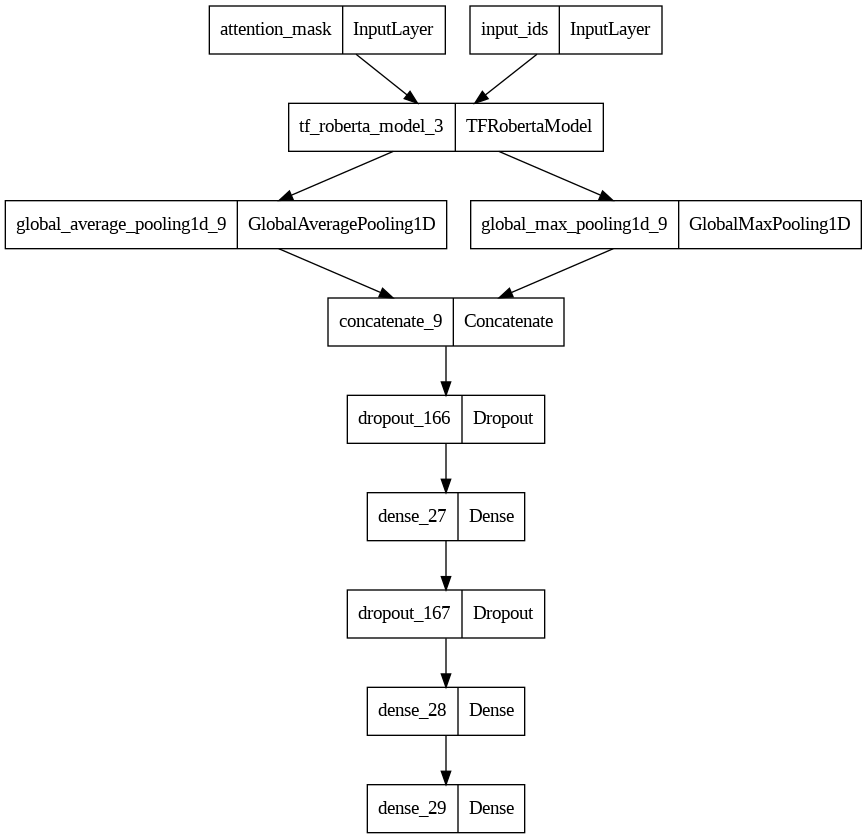

In [ ]:
tf.keras.utils.plot_model(model)

**Model Architecture Summary**

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 tf_roberta_model_3 (TFRobertaM  TFBaseModelOutputWi  124645632  ['attention_mask[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, None                                         

**Training Configuration**

In [ ]:
with strategy.scope(): 
  # Define model's callbacks
  early_stop = EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1, restore_best_weights=True)
  reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-8)

  # Compile the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7, epsilon=1e-08)

  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='accuracy')

  # Train the model
  history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[reduce_lr, early_stop])

Epoch 1/30


55/55 [==============================] - 154s 1s/step - loss: 2.4061 - accuracy: 0.3022 - val_loss: 2.1049 - val_accuracy: 0.3567 - lr: 1.0000e-07
Epoch 2/30
55/55 [==============================] - 11s 202ms/step - loss: 2.2458 - accuracy: 0.3613 - val_loss: 1.9758 - val_accuracy: 0.4900 - lr: 1.0000e-07
Epoch 3/30
55/55 [==============================] - 11s 204ms/step - loss: 2.1148 - accuracy: 0.4170 - val_loss: 1.8643 - val_accuracy: 0.5455 - lr: 1.0000e-07
Epoch 4/30
55/55 [==============================] - 11s 202ms/step - loss: 2.0067 - accuracy: 0.4623 - val_loss: 1.7693 - val_accuracy: 0.5879 - lr: 1.0000e-07
Epoch 5/30
55/55 [==============================] - 11s 202ms/step - loss: 1.9073 - accuracy: 0.5071 - val_loss: 1.6932 - val_accuracy: 0.6459 - lr: 1.0000e-07
Epoch 6/30
55/55 [==============================] - 11s 203ms/step - loss: 1.8117 - accuracy: 0.5584 - val_loss: 1.6319 - val_accuracy: 0.7403 - lr: 1.0000e-07
Epoch 7/30
55/55 [==============================] - 1

**Performnace Indicators**

Accuracy

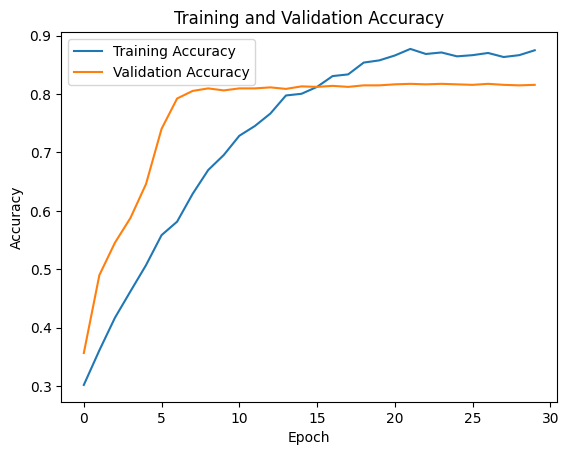

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Loss

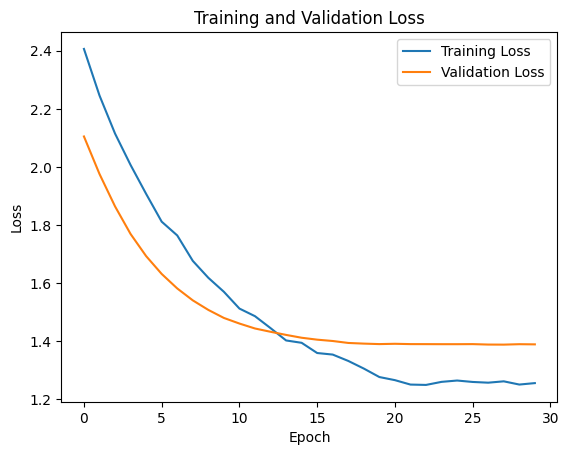

In [ ]:
# Plot the training and validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Save Model**

In [ ]:
model.save('RoBERTA.h5')
model.save('/content/drive/MyDrive/RoBERTA_8156.h5')

**Load the model for offline Evaluation**

In [ ]:
# Load the saved model
# Register the custom object TFRobertaModel
# Define the TFRobertaModel layer
tf.keras.utils.get_custom_objects()['TFRobertaModel'] = TFRobertaModel
model = tf.keras.models.load_model('/content/drive/MyDrive/RoBERTA_8156.h5')

**Evaluate the model**

Confusion Matrix

4/4 [==============================] - 1s 54ms/step


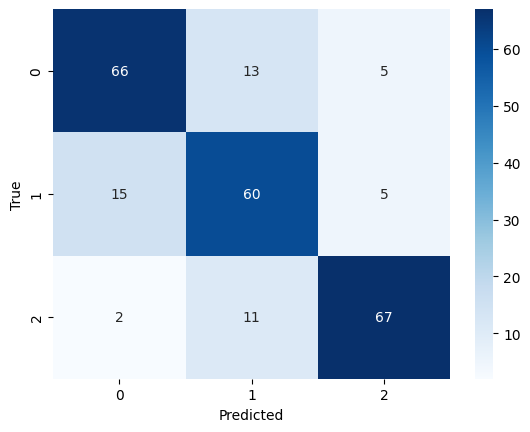

In [ ]:
# Predict the test dataset
test_pred = model.predict(test_dataset)
test_pred_labels = np.argmax(test_pred, axis=1)


# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_pred_labels)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

F1 score, Recall and Precision

4/4 [==============================] - 1s 54ms/step
Precision:  0.7931987691023835
Recall:  0.7910714285714285
F1 Score:  0.791876554487731


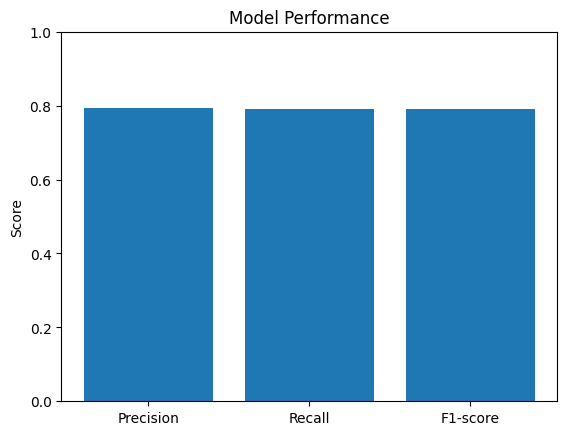

In [ ]:
# make predictions with your model
test_pred = model.predict(test_dataset)

# calculate precision, recall, f1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, test_pred.argmax(axis=1), average='macro')
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)
# plot the results
fig, ax = plt.subplots()
ax.bar(['Precision', 'Recall', 'F1-score'], [precision, recall, f1_score])
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Model Performance')
plt.show()